In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import os


In [2]:
openmc_data = "/home/agusgimenez/KD_OPMC/Secciones/endfb-vii.1-hdf5/cross_sections.xml"
os.environ['OPENMC_CROSS_SECTIONS'] = openmc_data
openmc.config['cross_sections'] = openmc_data

In [3]:
umet = openmc.Material()
umet.add_nuclide("U235", 0.9473, 'wo')
umet.add_nuclide("U238", 0.0527, 'wo')
umet.add_nuclide("U234", 0.0102, 'wo')
umet.set_density("g/cm3", 18.74)




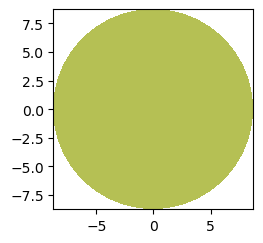

In [4]:
R = 8.7407
esfera = openmc.Sphere(r = R, boundary_type="vacuum")
godiva = openmc.Cell(region = -esfera, fill=umet)
simulacion = openmc.Universe(cells=[godiva])

simulacion.plot(width=(2*R , 2*R))




In [5]:
run = openmc.Settings()
run.run_mode = "eigenvalue"
run.particles = 10000
run.batches = 110
run.inactive = 10
run.photon_transport = True


In [6]:
tallies = openmc.Tallies()



#LIMITES ENERGIA
values_neutron  = np.logspace(np.log10(1e-5), np.log10(2e7), 201)
values_photon   = np.linspace(0, 2e7, 201)


#FILTRO ENERGIA 
Filtro_Energia_neutron      =   openmc.filter.EnergyFilter(values_neutron,filter_id =  0)
Filtro_Energia_photon       =   openmc.filter.EnergyFilter(values_photon,filter_id = 2)


#FILTRO PARTICULA
Filtro_particula_neutron    =   openmc.ParticleFilter(['neutron'],filter_id = 1)
Filtro_particula_photon     =   openmc.ParticleFilter(['photon'],filter_id = 3)


#GRILLA
mesh = openmc.RegularMesh(mesh_id=1)
mesh.lower_left = [-R, -R, -R]
mesh.upper_rigth = [R, R, R]
mesh.dimension = [100, 100, 1]

#FILTRO ESPACIAL
Filtro_espacio = openmc.filter.MeshFilter(mesh,filter_id=5)



#TALLY
espectro_neutron            = openmc.Tally(name = "PHI_n",tally_id=1)
espectro_neutron.scores   = ["flux"]
espectro_neutron.filters = [Filtro_Energia_neutron, Filtro_particula_neutron]
tallies.append(espectro_neutron)


espectro_photon         = openmc.Tally(name = "PHI_p",tally_id=2)
espectro_photon.scores   = ["flux"]
espectro_photon.filters = [Filtro_Energia_photon, Filtro_particula_photon]
tallies.append(espectro_photon)

distribucion_espacial = openmc.Tally(name='PHI_xy' , tally_id= 3)
distribucion_espacial.scores = ["flux"]
distribucion_espacial.filters = [Filtro_espacio, Filtro_particula_neutron]




In [7]:
geom = openmc.Geometry(simulacion)
geom.export_to_xml()


mats = openmc.Materials(geom.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()

run.export_to_xml()

tallies.export_to_xml()

!cat geometry.xml
!cat materials.xml
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" region="-1" universe="1" />
  <surface boundary="vacuum" coeffs="0.0 0.0 0.0 8.7407" id="1" type="sphere" />
</geometry>
<?xml version='1.0' encoding='utf-8'?>
<materials>
  <cross_sections>/home/agusgimenez/KD_OPMC/Secciones/endfb-vii.1-hdf5/cross_sections.xml</cross_sections>
  <material depletable="true" id="1">
    <density units="g/cm3" value="18.74" />
    <nuclide name="U235" wo="0.9473" />
    <nuclide name="U238" wo="0.0527" />
    <nuclide name="U234" wo="0.0102" />
  </material>
</materials>
<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>10000</particles>
  <batches>110</batches>
  <inactive>10</inactive>
  <photon_transport>true</photon_transport>
</settings>


In [8]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

rm: cannot remove 'statepoint.*.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #####################

In [13]:
sp=openmc.StatePoint('statepoint.110.h5')      #abro el statepoint
S0=1.0 #[n/s]

In [14]:



##Energia
dV = 4/3*np.pi*R**3

#Neutrones
data_n = sp.get_tally(name="PHI_n").get_pandas_dataframe(nuclides = False)
data_n.columns = ['Emin','Emax','particle','score','mean','stdv']
Emin_n = data_n['Emin']
Emax_n = data_n['Emax']
dE_n = Emax_n-Emin_n
E_n = (Emax_n + Emin_n)/2.0



mean_n = data_n['mean']*S0/(dE_n*dV)
stdv_n = data_n['stdv']*S0/(dE_n*dV)

#Fotones
data_p = sp.get_tally(name="PHI_p").get_pandas_dataframe(nuclides = False)
data_p.columns = ['Emin','Emax','particle','score','mean','stdv']
Emin_p = data_p['Emin']
Emax_p = data_p['Emax']
dE_p = Emax_p-Emin_p
E_p = (Emax_p + Emin_p)/2.0

mean_p = data_p['mean']*S0/(dE_p*dV)
stdv_p = data_p['stdv']*S0/(dE_p*dV)
##Espacio


In [15]:
print(mean_n)

0      0.000000e+00
1      0.000000e+00
2      0.000000e+00
3      0.000000e+00
4      0.000000e+00
           ...     
195    1.091855e-12
196    3.221209e-13
197    6.429527e-14
198    1.212098e-14
199    2.718163e-15
Length: 200, dtype: float64


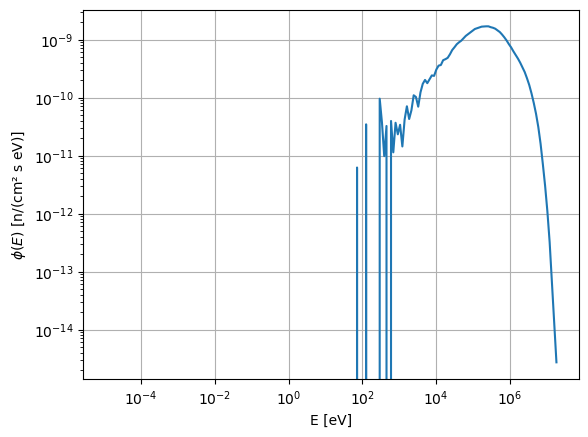

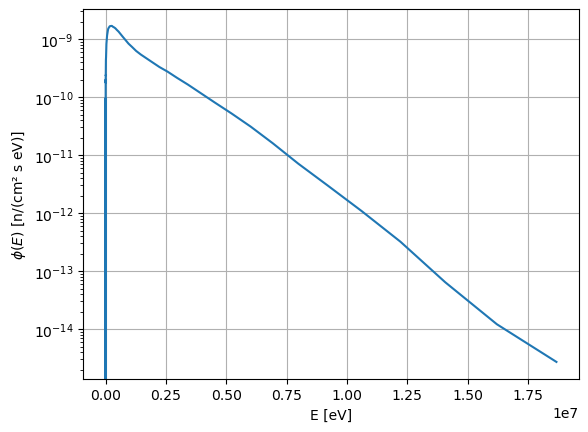

In [17]:
plt.loglog(E_n,mean_n)
plt.xlabel('E [eV]')
plt.ylabel('$\phi(E)$ [n/(cm² s eV)]')
plt.grid()
plt.show()


plt.semilogy(E_n,mean_n)
plt.xlabel('E [eV]')
plt.ylabel('$\phi(E)$ [n/(cm² s eV)]')
plt.grid()
plt.show()

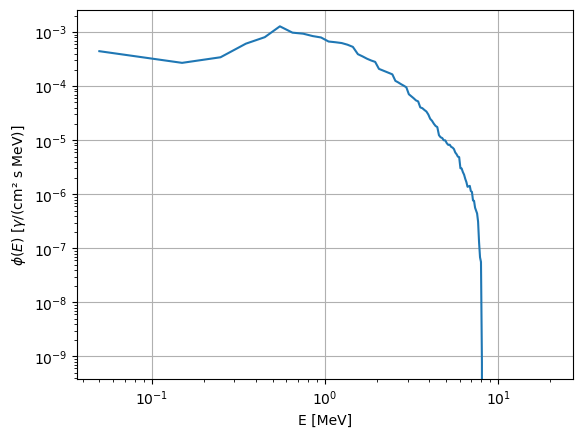

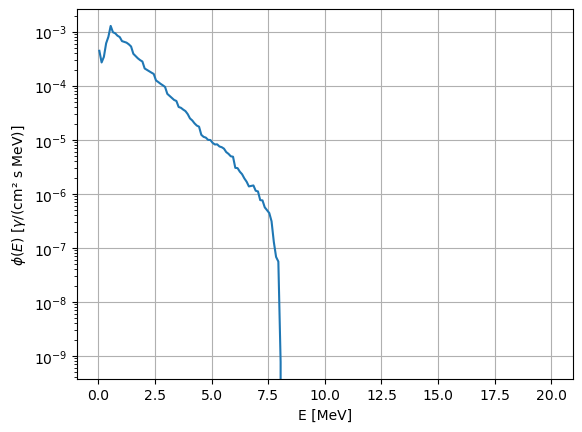

In [19]:
plt.loglog(E_p*1e-6,mean_p*1e6)
plt.xlabel('E [MeV]')
plt.ylabel('$\phi(E)$ [$\gamma$/(cm² s MeV)]')
plt.grid()
plt.show()

plt.semilogy(E_p*1e-6,mean_p*1e6)
plt.xlabel('E [MeV]')
plt.ylabel('$\phi(E)$ [$\gamma$/(cm² s MeV)]')
plt.grid()
plt.show()